In [ ]:
inputPath = ""
outputPath = ""

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

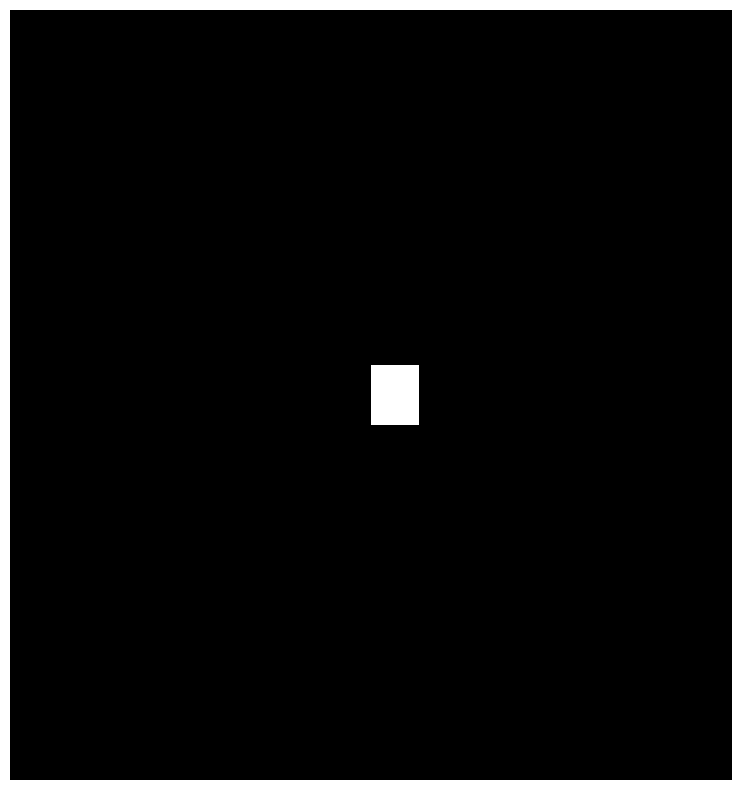

In [7]:
import numpy as np
import matplotlib.pyplot as plt

hexFile = []

with open(inputPath, 'rb') as f:
    byte = f.read(1)
    while byte:
        # Convert byte to a 2-character hex string, e.g., '6A'
        hex_value = format(ord(byte), '02x')
        # Extend the list with the hex value
        hexFile.append(hex_value)
        byte = f.read(1)

# Remove the first 20 bytes (header)
# magic + 16 bytes (unknown)
hexFile = hexFile[4+16:]

bit_array = []

rows = len(hexFile) // 16

for i in range(rows - 1, -1, -1):   
    row = []
    for j in range(15): # 15 as the last byte is end of line marker of some sort
        # Read one byte
        byte = hexFile[i  * 16 + j]
        # Convert it into bits
        bits = format(int(byte, 16), '08b')
        # Reverse the bits
        bits = bits[::-1]
        # Convert the bits to integers
        bits = [int(bit) for bit in bits]
        # Append the bits to the row
        row.extend(bits)
    bit_array.append(row)

print(bit_array)

# Convert the list to a NumPy array
bit_array = np.array(bit_array)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
# Display the array as an image
ax.imshow(bit_array, cmap='gray', interpolation='nearest')
# Hide the axes
ax.axis('off')
# Show the plot
plt.show()

# Save the image
plt.imsave(outputPath, bit_array, cmap='gray', format='png')